In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Asus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load dataset (download from Kaggle or use below path)
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']

print(df.head())
print(f"Total samples: {len(df)}")
print(df['label'].value_counts())


  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
Total samples: 5572
label
ham     4825
spam     747
Name: count, dtype: int64


In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)
    # Tokenize & remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)
print(df[['text', 'clean_text']].head())


                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                          clean_text  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4           nah dont think go usf life around though  


In [4]:
X = df['clean_text']
y = df['label'].map({'ham':0, 'spam':1})  # convert to 0/1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
tfidf = TfidfVectorizer(max_features=3000)  # limit vocab size for speed
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")


Train shape: (4457, 3000)
Test shape: (1115, 3000)


In [6]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

Accuracy: 0.9686


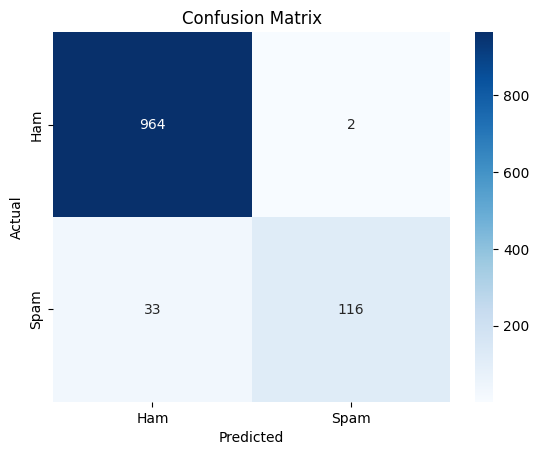

              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       0.98      0.78      0.87       149

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [7]:
y_pred = model.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


In [8]:
feature_names = tfidf.get_feature_names_out()
coef = model.coef_[0]

top_spam = np.argsort(coef)[-10:]
top_ham = np.argsort(coef)[:10]

print("Top words indicating SPAM:")
for i in reversed(top_spam):
    print(f"{feature_names[i]}: {coef[i]:.3f}")

print("\nTop words indicating HAM:")
for i in top_ham:
    print(f"{feature_names[i]}: {coef[i]:.3f}")


Top words indicating SPAM:
txt: 4.961
claim: 3.710
stop: 3.452
call: 3.314
mobile: 3.309
text: 3.255
reply: 3.247
service: 3.195
free: 3.176
prize: 2.799

Top words indicating HAM:
ltgt: -1.984
im: -1.944
ill: -1.789
ok: -1.706
sir: -1.394
later: -1.383
home: -1.299
sorry: -1.230
got: -1.184
hey: -1.127
